1, 7 (8,12 ec)

## 1

Consider a neural network with two hidden layers: p = 4 input units,
2 units in the first hidden layer, 3 units in the second hidden layer,
and a single output.

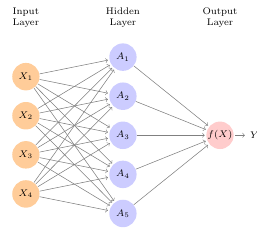
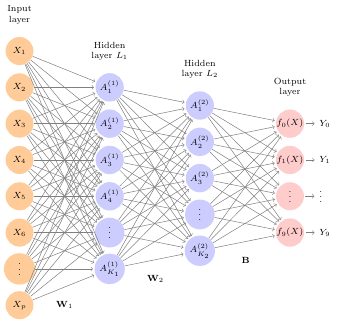

Fig 10.1, Fig 10.4

(a) Draw a picture of the network, similar to Figures 10.1 or 10.4.

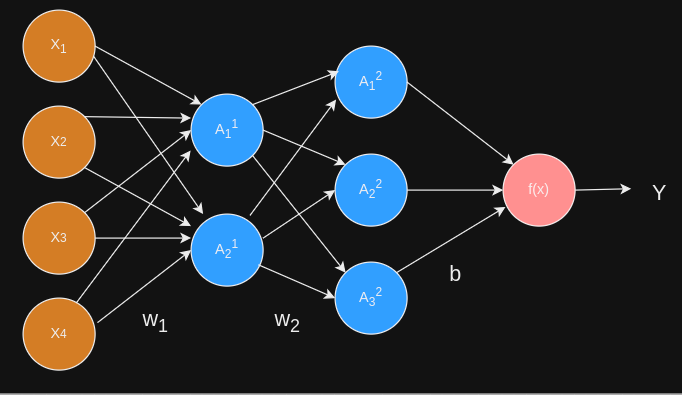

(b) Write out an expression for f (X), assuming ReLU activation
functions. Be as explicit as you can!

\begin{align*}
A_k^{(1)} &= h_k^{(1)}(X) = g(w_{k0}^{(1)} + \sum_{j=1}^p w_{kj}^{(1)} X_j) \\
A_l^{(2)} &= h_l^{(2)}(X) = g(w_{l0}^{(2)} + \sum_{k=1}^{K_1} w_{lk}^{(2)} A_k^{(1)})\\
f(X) &= g(\beta_{0} + \sum^{K_2}_{l=1} w_{l} A_l) \\
\end{align*}
<!-- 
\begin{align*}
f(X) &= g(\beta_{0} + \sum^{K_2}_{l=1} w_{l} A_l) \\
A_l^{(2)} &= h_l^{(2)}(X) = g(w_{l0}^{(2)} + \sum_{k=1}^{K_1} w_{lk}^{(2)} A_k^{(1)})\\
A_k^{(1)} &= h_k^{(1)}(X) = g(w_{k0}^{(1)} + \sum_{j=1}^p w_{kj}^{(1)} X_j) \\
\end{align*} -->

where,

$$
g(z) = (z)_+ = \begin{cases}
  0, & \text{if } z < 0 \\
  z, & \text{otherwise}
\end{cases}
$$

(c) Now plug in some values for the coefficients and write out the
value of f (X).

Activations for input: [1. 2. 3. 4.]
Activations for hidden1: [0. 0.]
Activations for hidden2: [1.1111193  0.         0.12688392]
Activations for output: [-2.388536]
Output of the network for the input X: tensor([-2.3885], grad_fn=<ViewBackward0>)


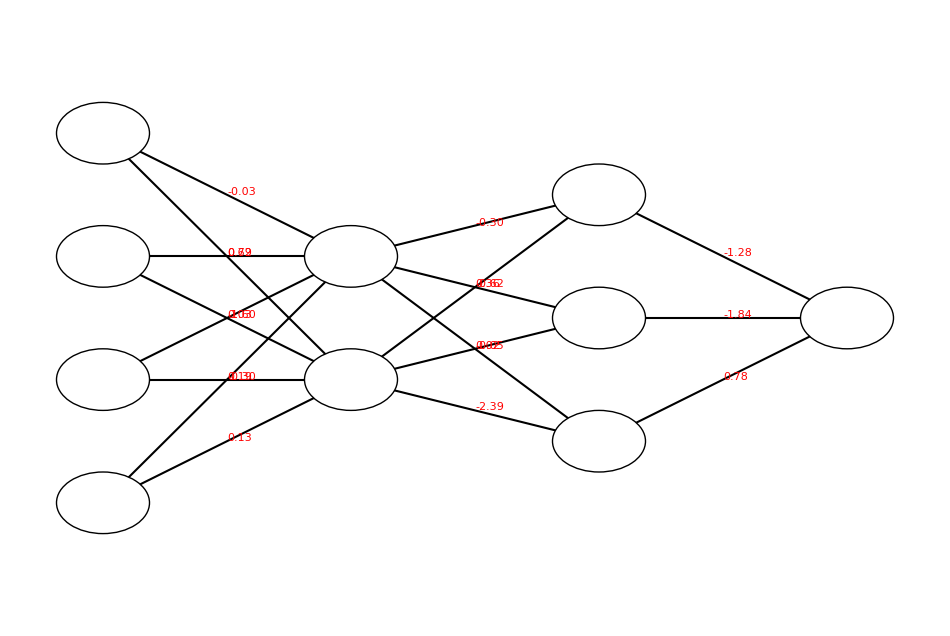

In [48]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx

# Define the neural network class
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.hidden1 = nn.Linear(4, 2)
        self.hidden2 = nn.Linear(2, 3)
        self.output = nn.Linear(3, 1)
        
        # Initialize weights and biases for demonstration
        self.hidden1.weight = nn.Parameter(torch.randn(2, 4))
        self.hidden1.bias = nn.Parameter(torch.randn(2))
        self.hidden2.weight = nn.Parameter(torch.randn(3, 2))
        self.hidden2.bias = nn.Parameter(torch.randn(3))
        self.output.weight = nn.Parameter(torch.randn(1, 3))
        self.output.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        activations = {} # Store the activations for visualization
        activations = {'input': x.detach().numpy()}  # Add input layer activations
        x = torch.relu(self.hidden1(x))
        activations['hidden1'] = x.detach().numpy()
        x = torch.relu(self.hidden2(x))
        activations['hidden2'] = x.detach().numpy()
        x = self.output(x)
        activations['output'] = x.detach().numpy()
        return x, activations

# Initialize the network and input
net = SimpleNeuralNetwork()
X = torch.tensor([1.0, 2.0, 3.0, 4.0])  # Example input
output, activations = net(X)

# Extract weights
weights = {
    'hidden1': net.hidden1.weight.data.numpy(),
    'hidden2': net.hidden2.weight.data.numpy(),
    'output': net.output.weight.data.numpy()
}

# Visualization function
def draw_neural_net(ax, layer_sizes, weights, activations):
    left, right, bottom, top = .1, .9, .1, .9
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    node_positions = {}
    
    # Nodes
    for i, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for j in range(layer_size):
            node_position = (left + i*h_spacing, layer_top - j*v_spacing)
            node_positions[(i, j)] = node_position
            circle = plt.Circle(node_position, v_spacing/4., color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            if i > 0:
                activation = activations[f'hidden{i}' if i < len(layer_sizes) - 1 else 'output'][j]
                ax.annotate(f'{activation:.2f}', node_position, color='black', fontsize=12, ha='center', va='center')
    
    # Edges
    for i, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_weights = weights[f'hidden{i+1}' if i < len(layer_sizes) - 2 else 'output']
        for j in range(layer_size_a):
            for k in range(layer_size_b):
                line = plt.Line2D(*zip(*[node_positions[(i, j)], node_positions[(i + 1, k)]]), c='k')
                ax.add_artist(line)
                ax.annotate(f'{layer_weights[k, j]:.2f}', 
                            ((node_positions[(i, j)][0] + node_positions[(i + 1, k)][0]) / 2,
                             (node_positions[(i, j)][1] + node_positions[(i + 1, k)][1]) / 2), 
                            color='red', fontsize=8)

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, [4, 2, 3, 1], weights, activations)
for layer, activation in activations.items():
    print(f'Activations for {layer}: {activation}')
print("Output of the network for the input X:", output)
plt.show()

(d) How many parameters are there?

In [49]:
# show number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("Number of parameters in the network:", count_parameters(net))

Number of parameters in the network: 23


## 7

Fit a neural network to the Default data. Use a single hidden layer
with 10 units, and dropout regularization. Have a look at Labs 10.9.1–
10.9.2 for guidance. Compare the classification performance of your
model with that of linear logistic regression.

In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data

In [2]:
default_data = load_data('Default')

In [3]:
default_data

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [4]:
# encode No/Yes to 0/1
default_data['default'] = (default_data['default'] == 'Yes').astype(int)
default_data['student'] = (default_data['student'] == 'Yes').astype(int)

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import TensorDataset
from ISLP.torch import SimpleDataModule, SimpleModule
from pytorch_lightning import Trainer

# Assuming the data is in a file named "default.csv"
data = default_data

# Separate features and target
X = data.drop("default", axis=1)
y = data["default"]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_scaled.astype(np.float32))
X_test_t = torch.tensor(X_test_scaled.astype(np.float32))
y_train_t = torch.tensor(y_train.values.astype(np.float32))
y_test_t = torch.tensor(y_test.values.astype(np.float32))

# Create data module
data_module = SimpleDataModule(
    TensorDataset(X_train_t, y_train_t),
    TensorDataset(X_test_t, y_test_t),
    batch_size=32,
)

class DefaultModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x.squeeze(1)  # Squeeze the last dimension

In [34]:
# Instantiate the model
model = DefaultModel(X_train_scaled.shape[1])

# Create a simple module for binary classification
module = SimpleModule.binary_classification(model)

# Train the model
trainer = Trainer(max_epochs=20)
trainer.fit(module, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | DefaultModel      | 51    
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)


/home/jake/miniconda3/envs/mathenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/jake/miniconda3/envs/mathenv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
/home/jake/miniconda3/envs/mathenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 1/219 [00:00<00:04, 46.71it/s, v_num=9]

Epoch 19: 100%|██████████| 219/219 [00:01<00:00, 191.35it/s, v_num=9]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 219/219 [00:01<00:00, 190.69it/s, v_num=9]


In [35]:
# Evaluate the neural network on the test set
trainer.test(module, data_module)

# Fit and evaluate logistic regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
print("Logistic Regression Accuracy:", logreg.score(X_test_scaled, y_test))

/home/jake/miniconda3/envs/mathenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 94/94 [00:00<00:00, 568.61it/s]
Logistic Regression Accuracy: 0.9736666666666667


## 8

From your collection of personal photographs, pick 10 images of an-
imals (such as dogs, cats, birds, farm animals, etc.). If the subject
does not occupy a reasonable part of the image, then crop the image.
Now use a pretrained image classification CNN as in Lab 10.9.4 to
predict the class of each of your images, and report the probabilities
for the top five predicted classes for each image.

## 12

Consider the RNN fit to the NYSE data in Section 10.9.6. Modify the
code to allow inclusion of the variable day_of_week, and fit the RNN.
Compute the test R2 .